# The Davies-Jones wet bulb temperature calculation <a class='tocSkip'></a>

Thomas Schanzer z5310829  
School of Physics, UNSW  
October 2021

In this notebook, we implement the methods outlined in *Davies-Jones (2008)*$^1$ for calculating wet bulb potential temperature and wet bulb temperature from equivalent potential temperature. We will see that they are both accurate and significantly faster than the corresponding functions provided by MetPy.

$^1$Davies-Jones, R 2008, ‘An Efficient and Accurate Method for Computing the Wet-Bulb Temperature along Pseudoadiabats’, *Monthly weather review*, vol. 136, no. 7, pp. 2764–2785

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#$\theta_W$-from-$\theta_E$" data-toc-modified-id="$\theta_W$-from-$\theta_E$-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>$\theta_W$ from $\theta_E$</a></span></li><li><span><a href="#$T_W$-from-$\theta_E$" data-toc-modified-id="$T_W$-from-$\theta_E$-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>$T_W$ from $\theta_E$</a></span></li><li><span><a href="#Comparison-with-MetPy" data-toc-modified-id="Comparison-with-MetPy-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Comparison with MetPy</a></span><ul class="toc-item"><li><span><a href="#Saturated-parcel-$\theta_W$" data-toc-modified-id="Saturated-parcel-$\theta_W$-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Saturated parcel $\theta_W$</a></span></li><li><span><a href="#Saturated-parcel-$T_W$" data-toc-modified-id="Saturated-parcel-$T_W$-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Saturated parcel $T_W$</a></span></li><li><span><a href="#Subsaturated-parcel-$\theta_W$" data-toc-modified-id="Subsaturated-parcel-$\theta_W$-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Subsaturated parcel $\theta_W$</a></span></li><li><span><a href="#Subsaturated-parcel-$T_W$" data-toc-modified-id="Subsaturated-parcel-$T_W$-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Subsaturated parcel $T_W$</a></span></li></ul></li></ul></div>

In [191]:
import numpy as np
from metpy.units import units
import metpy.calc as mpcalc
import sys
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

sys.path.append('../../scripts/')
from thermo import moist_lapse

## $\theta_W$ from $\theta_E$

In [337]:
def theta_w(theta_e):
    """
    Calculates theta-w from theta-e using Eq. 3.8 of Davies-Jones 2008.
    
    Args:
        theta_e: Equivalent potential temperature.
        
    Returns:
        Wet bulb potential temperature.
    """
    
    theta_e = theta_e.m_as(units.kelvin)
    
    C=273.15
    X = theta_e/C
    
    # coefficients
    a0 = 7.101574
    a1 = -20.68208
    a2 = 16.11182
    a3 = 2.574631
    a4 = -5.205688
    b1 = -3.552497
    b2 = 3.781782
    b3 = -0.6899655
    b4 = -0.5929340
    
    theta_w = (
        theta_e - C
        - np.exp((a0 + a1*X + a2*X**2 + a3*X**3 + a4*X**4)
              /(1 + b1*X + b2*X**2 + b3*X**3 + b4*X**4))*(theta_e >= 173.15)
    )
    
    return theta_w*units.celsius

## $T_W$ from $\theta_E$

In [190]:
def daviesjones_f(Tw, pi):
    """
    Evaluates the function f defined in eq. 2.3 of Davies-Jones 2008.
    
    Args:
        Tw: Wet-bulb temperature in KELVIN.
        pi: Nondimensional pressure.
        
    Returns:
        The value of f(Tw, pi).
    """
    
    pressure = 1000.0 * pi**3.504  # in mbar
    
    # coefficients
    k0 = 3036
    k1 = 1.78
    k2 = 0.448
    nu = 0.2854  # poisson constant for dry air
    C = 273.15
    
    # saturation mixing ratio and vapour pressure calculated using
    # eq. 10 of Bolton 1980
    rs = mpcalc.saturation_mixing_ratio(
        pressure*units.mbar, Tw*units.kelvin).m_as(units.dimensionless)
    es = mpcalc.saturation_vapor_pressure(Tw*units.kelvin).m_as(units.mbar)
    
    G = (k0/Tw - k1)*(rs + k2*rs**2)
    f = (C/Tw)**3.504 * (1 - es/pressure)**(3.504*nu) * np.exp(-3.504*G)
    
    return f

In [229]:
def daviesjones_fprime(tau, pi):
    """
    Evaluates df/dtau (pi fixed) defined in eqs. A.1-A.5 of Davies-Jones 2008.
    
    Args:
        tau: Temperature in KELVIN.
        pi: Nondimensional pressure.
        
    Returns:
        The value of f'(Tau, pi) for fixed pi.
    """
    
    pressure = 1000.0 * pi**3.504  # in mbar
    
    # coefficients
    k0 = 3036
    k1 = 1.78
    k2 = 0.448
    nu = 0.2854  # poisson constant for dry air
    C = 273.15
    epsilon = 0.6220
    
    # saturation mixing ratio and vapour pressure calculated using
    # eq. 10 of Bolton 1980
    rs = mpcalc.saturation_mixing_ratio(
        pressure*units.mbar, tau*units.kelvin).m_as(units.dimensionless)
    es = mpcalc.saturation_vapor_pressure(tau*units.kelvin).m_as(units.mbar)
    
    des_dtau = es*17.67*243.5/(tau - C + 243.5)**2  # eq. A.5
    drs_dtau = epsilon*pressure/(pressure - es)**2 * des_dtau  # eq. A.4
    dG_dtau = (-k0/tau**2 * (rs + k2*rs**2)
               + (k0/tau - k1)*(1 + 2*k2*rs)*drs_dtau)  # eq. A.3
    dlogf_dtau = -3.504*(1/tau + nu/(pressure - es)*des_dtau
                         + dG_dtau)  # eq. A.2
    df_dtau = daviesjones_f(tau, pi) * dlogf_dtau  # eq. A.1
    
    return df_dtau

In [291]:
def wetbulb(pressure, theta_e, improve=False):
    """
    Calculates wet bulb temperature using the method in Davies-Jones 2008.
    
    Args:
        pressure: Pressure.
        theta_e: Equivalent potential temperature.
        improve: Whether or not to perform a single iteration of
            Newton's method to improve accuracy (defaults to False).
            
    Returns:
        Wet bulb temperature.
    """
    
    # changing to correct units
    pressure = pressure.m_as(units.mbar)
    theta_e = theta_e.m_as(units.kelvin)
    
    pi = (pressure/1000.0)**(1./3.504)
    Teq = theta_e*pi
    C = 273.15
    X = (C/Teq)**3.504
    
    # slope and intercept for guesses - eq. 4.3, 4.4
    k1 = -38.5*pi**2 + 137.81*pi - 53.737
    k2 = -4.392*pi**2 + 56.831*pi - 0.384
    
    # transition point between approximation schemes - eq. 4.7
    D = 1/(0.1859*pressure/1000 + 0.6512)
    
    # initial guess
    if X > D:
        A = 2675.0
        # saturation mixing ratio calculated via vapour pressure using
        # eq. 10 of Bolton 1980
        rs = mpcalc.saturation_mixing_ratio(
            pressure*units.mbar, Teq*units.kelvin).m_as(units.dimensionless)
        # d(log(e_s))/dT calculated also from eq. 10, Bolton 1980
        d_log_es_dt = 17.67*243.5/(Teq + 243.5)**2
        
        # approximate wet bulb temperature in celsius
        Tw = Teq - C - A*rs/(1 + A*rs*d_log_es_dt)
    elif 1 <= X <= D:
        Tw = k1 - k2*X
    elif 0.4 <= X < 1:
        Tw = (k1 - 1.21) - (k2 - 1.21)*X
    else:
        Tw = (k1 - 2.66) - (k2 - 1.21)*X + 0.58/X
    
    if improve:
        # execute a single iteration of Newton's method (eq. 2.6)
        slope = daviesjones_fprime(Tw + C, pi)
        fvalue = daviesjones_f(Tw + C, pi)
        Tw = Tw - (fvalue - X)/slope
        
    return Tw*units.celsius

In [253]:
def wetbulb_exact(pressure, theta_e):
    """
    Calculates the fully-converged Davies-Jones wet bulb temperature.
    
    Uses Newton's method.
    
    Args:
        pressure: Pressure.
        theta_e: Equivalent potential temperature.
            
    Returns:
        Wet bulb temperature.
    """
    
    pi = (pressure.m_as(units.mbar)/1000.0)**(1./3.504)
    equivalent_temperature = theta_e.m_as(units.kelvin)*pi
    X = (273.15/equivalent_temperature)**3.504
    guess = wetbulb(pressure, theta_e).m_as(units.kelvin)
    def root(Tw):
        return (daviesjones_f(Tw, pi) - X), daviesjones_fprime(Tw, pi)
    sol = root_scalar(root, x0=guess, fprime=True, method='newton')
    return sol.root*units.kelvin

## Comparison with MetPy
### Saturated parcel $\theta_W$

In [315]:
pressure = np.arange(100, 1001, 25)*units.mbar
temperature = np.arange(-40, 41, 2.5)*units.celsius
T, P = np.meshgrid(temperature, pressure)
ept = mpcalc.equivalent_potential_temperature(P, T, T)
maxept = 600*units.kelvin

In [160]:
%%time
wbpt_metpy = np.zeros((pressure.size, temperature.size))
for i in range(pressure.size):
    for ii in range(temperature.size):
        wbpt_metpy[i,ii] = moist_lapse(
            1000*units.mbar, temperature[ii], pressure[i]).m
wbpt_metpy = wbpt_metpy*units.celsius

CPU times: user 1min 16s, sys: 314 ms, total: 1min 16s
Wall time: 1min 17s


In [219]:
%%time
wbpt_dj = theta_w(ept)
wbpt_dj[ept > maxept] = np.nan

CPU times: user 1.37 ms, sys: 444 µs, total: 1.82 ms
Wall time: 1.29 ms


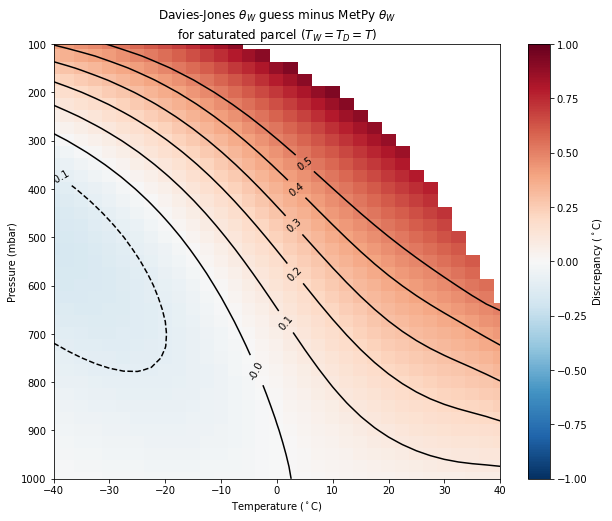

In [338]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

mesh = ax.pcolormesh(
    temperature, pressure, wbpt_dj - wbpt_metpy,
    shading='nearest', vmin=-1, vmax=1, cmap='RdBu_r')

contour = ax.contour(
    temperature, pressure, wbpt_dj - wbpt_metpy,
    levels=np.arange(-1, 0.6, 0.1),
    colors='k',
)
ax.clabel(contour, fmt='%1.1f')

cbar = plt.colorbar(mesh)
cbar.set_label(r'Discrepancy ($^\circ$C)')
ax.set_ylim(1000, 100)
ax.set(
    xlabel=r'Temperature ($^\circ$C)',
    ylabel='Pressure (mbar)',
    title=r'Davies-Jones $\theta_W$ guess minus MetPy $\theta_W$'
        '\nfor saturated parcel ($T_W=T_D=T$)')

plt.show()

Our implementation of the Davies-Jones method passes a quick sanity check against the MetPy values.

### Saturated parcel $T_W$

We expect to find that $T_W = T$ since the parcel is saturated. We use this to test the Davies-Jones method.

In [238]:
%%time
# Davies-Jones guess
wbt_dj_guess = np.zeros((pressure.size, temperature.size))
for i in range(pressure.size):
    for ii in range(temperature.size):
        wbt_dj_guess[i,ii] = wetbulb(pressure[i], ept[i,ii]).m
wbt_dj_guess = wbt_dj_guess*units.celsius
wbt_dj_guess[ept > maxept] = np.nan

CPU times: user 753 ms, sys: 5.57 ms, total: 759 ms
Wall time: 758 ms


In [245]:
%%time
# Davies-Jones improved
wbt_dj_improved = np.zeros((pressure.size, temperature.size))
for i in range(pressure.size):
    for ii in range(temperature.size):
        if ept[i,ii] < 600*units.kelvin:
            wbt_dj_improved[i,ii] = wetbulb(
                pressure[i], ept[i,ii], improve=True).m
        else:
            wbt_dj_improved[i,ii] = np.nan
wbt_dj_improved = wbt_dj_improved*units.celsius

CPU times: user 5.61 s, sys: 16.4 ms, total: 5.63 s
Wall time: 5.64 s


In [233]:
%%time
# Fully-converged Davies-Jones
wbt_dj_exact = np.zeros((pressure.size, temperature.size))
for i in range(pressure.size):
    for ii in range(temperature.size):
        if ept[i,ii] < 600*units.kelvin:
            wbt_dj_exact[i,ii] = wetbulb_exact(pressure[i], ept[i,ii]).m
        else:
            wbt_dj_exact[i,ii] = np.nan
wbt_dj_exact = wbt_dj_exact*units.kelvin

CPU times: user 16.9 s, sys: 43 ms, total: 17 s
Wall time: 17 s


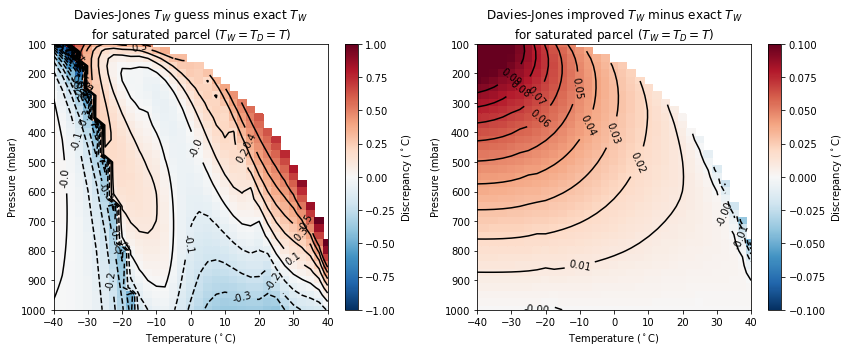

In [246]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(121)

mesh = ax.pcolormesh(
    temperature, pressure, wbt_dj_guess - temperature,
    shading='nearest', vmin=-1, vmax=1, cmap='RdBu_r')

contour = ax.contour(
    temperature, pressure, wbt_dj_guess - temperature,
    levels=np.arange(-1, 0.6, 0.1),
    colors='k',
)
ax.clabel(contour, fmt='%1.1f')

cbar = plt.colorbar(mesh)
cbar.set_label(r'Discrepancy ($^\circ$C)')
ax.set_ylim(1000, 100)
ax.set(
    xlabel=r'Temperature ($^\circ$C)',
    ylabel='Pressure (mbar)',
    title=r'Davies-Jones $T_W$ guess minus exact $T_W$'
        '\nfor saturated parcel ($T_W=T_D=T$)')

ax = fig.add_subplot(122)

mesh = ax.pcolormesh(
    temperature, pressure, wbt_dj_improved - temperature,
    shading='nearest', vmin=-0.1, vmax=0.1, cmap='RdBu_r')

contour = ax.contour(
    temperature, pressure, wbt_dj_improved - temperature,
    levels=np.arange(-0.1, 0.1, 0.01),
    colors='k',
)
ax.clabel(contour, fmt='%1.2f')

cbar = plt.colorbar(mesh)
cbar.set_label(r'Discrepancy ($^\circ$C)')
ax.set_ylim(1000, 100)
ax.set(
    xlabel=r'Temperature ($^\circ$C)',
    ylabel='Pressure (mbar)',
    title=r'Davies-Jones improved $T_W$ minus exact $T_W$'
        '\nfor saturated parcel ($T_W=T_D=T$)')

fig.tight_layout()
plt.show()

Left plot: the guess is well within 0.3 K for most values of $\theta_E$, consistent with the claim in the paper.  
Right plot: the error of the improved value is on the order of 0.01 K, which is larger than claimed but still satisfactory.

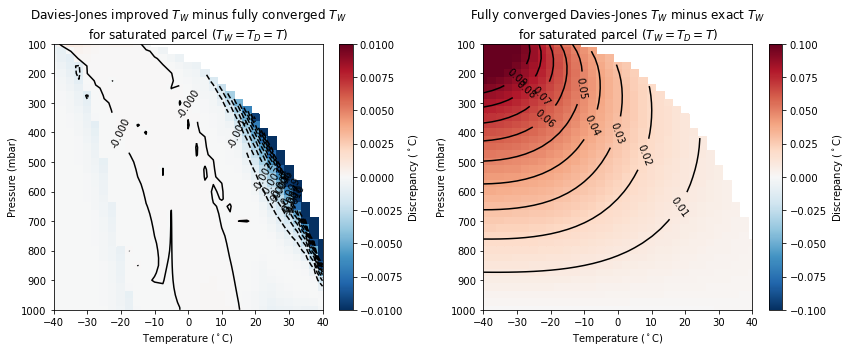

In [250]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(121)

mesh = ax.pcolormesh(
    temperature, pressure, wbt_dj_improved - wbt_dj_exact,
    shading='nearest', vmin=-0.01, vmax=0.01, cmap='RdBu_r')

contour = ax.contour(
    temperature, pressure, wbt_dj_improved - wbt_dj_exact,
    levels=np.arange(-0.01, 0.011, 0.001),
    colors='k',
)
ax.clabel(contour, fmt='%1.3f')

cbar = plt.colorbar(mesh)
cbar.set_label(r'Discrepancy ($^\circ$C)')
ax.set_ylim(1000, 100)
ax.set(
    xlabel=r'Temperature ($^\circ$C)',
    ylabel='Pressure (mbar)',
    title=r'Davies-Jones improved $T_W$ minus fully converged $T_W$'
        '\nfor saturated parcel ($T_W=T_D=T$)')

ax = fig.add_subplot(122)

mesh = ax.pcolormesh(
    temperature, pressure, wbt_dj_exact - temperature,
    shading='nearest', vmin=-0.1, vmax=0.1, cmap='RdBu_r')

contour = ax.contour(
    temperature, pressure, wbt_dj_exact - temperature,
    levels=np.arange(-0.1, 0.1, 0.01),
    colors='k',
)
ax.clabel(contour, fmt='%1.2f')

cbar = plt.colorbar(mesh)
cbar.set_label(r'Discrepancy ($^\circ$C)')
ax.set_ylim(1000, 100)
ax.set(
    xlabel=r'Temperature ($^\circ$C)',
    ylabel='Pressure (mbar)',
    title=r'Fully converged Davies-Jones $T_W$ minus exact $T_W$'
        '\nfor saturated parcel ($T_W=T_D=T$)')

fig.tight_layout()
plt.show()

Left plot: the improved value with only one iteration is within 0.001 K of the fully converged value almost everywhere.  
Right plot: the absolute error of the Davies-Jones method is on the order of 0.01 K.

### Subsaturated parcel $\theta_W$

We now set the dew point to be 5 degrees below the temperature to check the accuracy of the Davies-Jones method for subsaturated parcels.

In [259]:
pressure = np.arange(100, 1001, 25)*units.mbar
temperature = np.arange(-40, 41, 2.5)*units.celsius
T, P = np.meshgrid(temperature, pressure)
ept = mpcalc.equivalent_potential_temperature(P, T, (T.m-5)*units.celsius)
maxept = 600*units.kelvin

In [304]:
%%time
wbpt_metpy = np.zeros((pressure.size, temperature.size))
wbt_metpy = mpcalc.wet_bulb_temperature(P, T, (T.m-5)*units.celsius)
for i in range(pressure.size):
    for ii in range(temperature.size):
        wbpt_metpy[i,ii] = moist_lapse(
            1000*units.mbar, wbt_metpy[i,ii], pressure[i]).m
wbpt_metpy = wbpt_metpy*units.celsius

CPU times: user 1min 41s, sys: 164 ms, total: 1min 41s
Wall time: 1min 42s


In [285]:
%%time
wbpt_dj = theta_w(ept)
wbpt_dj[ept > maxept] = np.nan

CPU times: user 1.31 ms, sys: 46 µs, total: 1.35 ms
Wall time: 1.34 ms


The Davies-Jones method is 84000 times faster!

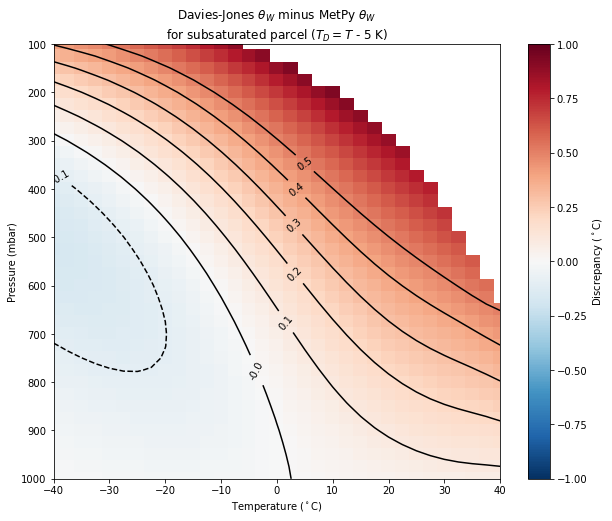

In [305]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

mesh = ax.pcolormesh(
    temperature, pressure, wbpt_dj - wbpt_metpy,
    shading='nearest', vmin=-1, vmax=1, cmap='RdBu_r')

contour = ax.contour(
    temperature, pressure, wbpt_dj - wbpt_metpy,
    levels=np.arange(-1, 0.6, 0.1),
    colors='k',
)
ax.clabel(contour, fmt='%1.1f')

cbar = plt.colorbar(mesh)
cbar.set_label(r'Discrepancy ($^\circ$C)')
ax.set_ylim(1000, 100)
ax.set(
    xlabel=r'Temperature ($^\circ$C)',
    ylabel='Pressure (mbar)',
    title=r'Davies-Jones $\theta_W$ minus MetPy $\theta_W$'
        '\nfor subsaturated parcel ($T_D = T$ - 5 K)')

plt.show()

Again, the Davies-Jones method passes a sanity check against MetPy.

### Subsaturated parcel $T_W$

In [306]:
%%time
# Davies-Jones guess
wbt_dj_guess = np.zeros((pressure.size, temperature.size))
for i in range(pressure.size):
    for ii in range(temperature.size):
        wbt_dj_guess[i,ii] = wetbulb(pressure[i], ept[i,ii]).m
wbt_dj_guess = wbt_dj_guess*units.celsius
wbt_dj_guess[ept > maxept] = np.nan

CPU times: user 713 ms, sys: 6.77 ms, total: 720 ms
Wall time: 723 ms


In [307]:
%%time
# Davies-Jones improved
wbt_dj_improved = np.zeros((pressure.size, temperature.size))
for i in range(pressure.size):
    for ii in range(temperature.size):
        if ept[i,ii] < 600*units.kelvin:
            wbt_dj_improved[i,ii] = wetbulb(
                pressure[i], ept[i,ii], improve=True).m
        else:
            wbt_dj_improved[i,ii] = np.nan
wbt_dj_improved = wbt_dj_improved*units.celsius

CPU times: user 5.79 s, sys: 14.2 ms, total: 5.8 s
Wall time: 5.81 s


In [308]:
%%time
# Fully-converged Davies-Jones
wbt_dj_exact = np.zeros((pressure.size, temperature.size))
for i in range(pressure.size):
    for ii in range(temperature.size):
        if ept[i,ii] < 600*units.kelvin:
            wbt_dj_exact[i,ii] = wetbulb_exact(pressure[i], ept[i,ii]).m
        else:
            wbt_dj_exact[i,ii] = np.nan
wbt_dj_exact = wbt_dj_exact*units.kelvin

CPU times: user 18 s, sys: 61.6 ms, total: 18.1 s
Wall time: 18.4 s


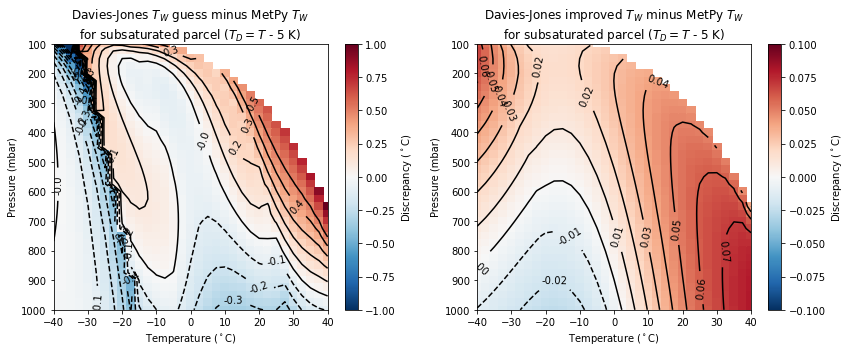

In [309]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(121)

mesh = ax.pcolormesh(
    temperature, pressure, wbt_dj_guess - wbt_metpy,
    shading='nearest', vmin=-1, vmax=1, cmap='RdBu_r')

contour = ax.contour(
    temperature, pressure, wbt_dj_guess - wbt_metpy,
    levels=np.arange(-1, 0.6, 0.1),
    colors='k',
)
ax.clabel(contour, fmt='%1.1f')

cbar = plt.colorbar(mesh)
cbar.set_label(r'Discrepancy ($^\circ$C)')
ax.set_ylim(1000, 100)
ax.set(
    xlabel=r'Temperature ($^\circ$C)',
    ylabel='Pressure (mbar)',
    title=r'Davies-Jones $T_W$ guess minus MetPy $T_W$'
        '\nfor subsaturated parcel ($T_D = T$ - 5 K)')

ax = fig.add_subplot(122)

mesh = ax.pcolormesh(
    temperature, pressure, wbt_dj_improved - wbt_metpy,
    shading='nearest', vmin=-0.1, vmax=0.1, cmap='RdBu_r')

contour = ax.contour(
    temperature, pressure, wbt_dj_improved - wbt_metpy,
    levels=np.arange(-0.1, 0.1, 0.01),
    colors='k',
)
ax.clabel(contour, fmt='%1.2f')

cbar = plt.colorbar(mesh)
cbar.set_label(r'Discrepancy ($^\circ$C)')
ax.set_ylim(1000, 100)
ax.set(
    xlabel=r'Temperature ($^\circ$C)',
    ylabel='Pressure (mbar)',
    title=r'Davies-Jones improved $T_W$ minus MetPy $T_W$'
        '\nfor subsaturated parcel ($T_D = T$ - 5 K)')

fig.tight_layout()
plt.show()

Left plot: the guess is well within 0.3 K for most values of $\theta_E$, consistent with the claim in the paper.  
Right plot: the difference between the improved and MetPy values is on the order of 0.01 K.

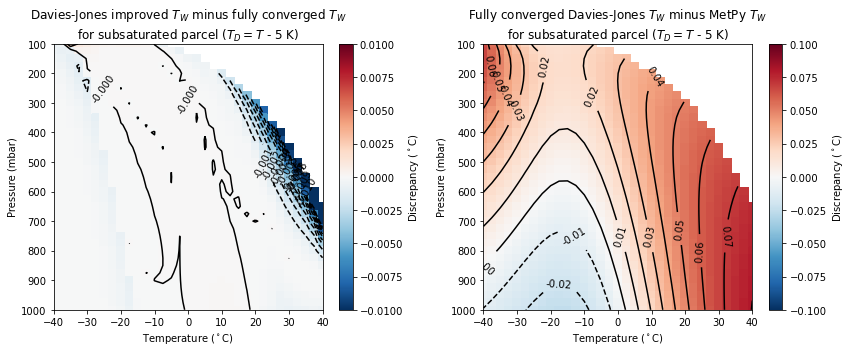

In [311]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(121)

mesh = ax.pcolormesh(
    temperature, pressure, wbt_dj_improved - wbt_dj_exact,
    shading='nearest', vmin=-0.01, vmax=0.01, cmap='RdBu_r')

contour = ax.contour(
    temperature, pressure, wbt_dj_improved - wbt_dj_exact,
    levels=np.arange(-0.01, 0.011, 0.001),
    colors='k',
)
ax.clabel(contour, fmt='%1.3f')

cbar = plt.colorbar(mesh)
cbar.set_label(r'Discrepancy ($^\circ$C)')
ax.set_ylim(1000, 100)
ax.set(
    xlabel=r'Temperature ($^\circ$C)',
    ylabel='Pressure (mbar)',
    title=r'Davies-Jones improved $T_W$ minus fully converged $T_W$'
        '\nfor subsaturated parcel ($T_D = T$ - 5 K)')

ax = fig.add_subplot(122)

mesh = ax.pcolormesh(
    temperature, pressure, wbt_dj_exact - wbt_metpy,
    shading='nearest', vmin=-0.1, vmax=0.1, cmap='RdBu_r')

contour = ax.contour(
    temperature, pressure, wbt_dj_exact - wbt_metpy,
    levels=np.arange(-0.1, 0.1, 0.01),
    colors='k',
)
ax.clabel(contour, fmt='%1.2f')

cbar = plt.colorbar(mesh)
cbar.set_label(r'Discrepancy ($^\circ$C)')
ax.set_ylim(1000, 100)
ax.set(
    xlabel=r'Temperature ($^\circ$C)',
    ylabel='Pressure (mbar)',
    title=r'Fully converged Davies-Jones $T_W$ minus MetPy $T_W$'
        '\nfor subsaturated parcel ($T_D = T$ - 5 K)')

fig.tight_layout()
plt.show()

Left plot: the improved value with only one iteration is within 0.001 K of the fully converged value almost everywhere.  